# CHAPTER 25: Decentralized Optimization I: Primal Methods

### This code runs simulations for Example 6 and generates figures 7, 8  from Chapter 25: Decentralized Optimization I: Primal Methods (vol I)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Semanur Avşar 

Required Libraries:

1. numpy
2. matplotlib

Required Functions:

1. generate_logistic
2. logistic_minimizer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm

In [2]:
from generate_logistic import generate_logistic
from logistic_minimizer import logistic_minimizer
from plot_topology import plot_topology
from generate_combination_policy import generate_combination_policy
from generate_topology import generate_topology
from find_Perron_vector import find_Perron_vector

## Example 25.6 (Simulating consensus and ATC diffusion)

Wait...generating data
network generated


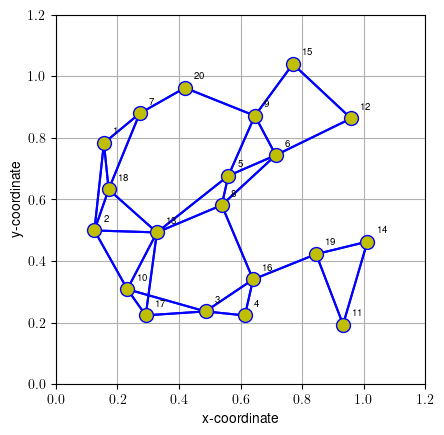

In [8]:
#################################################################################
# Runs EXAMPLE 6 from Chapter 25 (Simulating consensus and ATC diffusion
# generates figure 8 and 9 from Chapter 25
#################################################################################

#################################################################################
# Runs EXAMPLE 1 from Chapter 26 (Simulating EXTRA and EXACT diffusion)
# Runs EXAMPLE 2 from Chapter 26 (Simulating DIGing and ATC gradient tracking)
# generates figures 1 and 2 from Chapter 26
#################################################################################

rho = 0.001    # l2-regularization parameter
mu  = 0.01     # step-size 

M = 10     # feature size at each agent
K = 20     # number of agents in the network
Nk = 200   # number of data points per agent
N = K*Nk   # total number of data points across the graph

L = 1       # averaging over this many experiments
runs = 1000  # multiple runs at each agent using random reshuffling
alpha = (Nk/N)*np.ones(K) # scalings for all agents

random_agent = np.random.randint(K) # select a random agent to plot learning curves

type_policy = 'metropolis'  # Type of combination policy: uniform, metropolis, reldeg, reldegvar, relvar, hastings
type_topology = 1  # Use 1 for neighbors to be decided by closeness in distance; use 2 for neighbors to be decided randomly using binary decisions
radius = 0.3  # Size of radius to determine which nodes are neighbors for type_topology = 1
prob = 0.2  # Probability value to determine which nodes are neighbors for type_topology = 2

print('Wait...generating data')

# Generating the graph topology
if type_topology == 1:
    parameter = radius
else:
    parameter = prob

algebraic_connectivity = 0
while algebraic_connectivity < 1e-4:  # Keep trying until a connected topology is chosen
    result = generate_topology(K, type_topology, parameter)
    if result is not None:
        adjacency, laplacian, algebraic_connectivity, degree, coordinates = result
        break
        
print('network generated')

color = np.zeros(K)  # Color map for the agents: 0=yellow, 1=red, 2=green

# figure 8 from Chapter 25 (graph topology)
plot_topology(adjacency,coordinates,color)

b = np.ones(K).reshape(-1,1)
A, p = generate_combination_policy(adjacency, b, type_policy)  # A is the combination policy, p is its Perron eigenvector

A_EXTRA = 0.5 * (np.eye(K, K) + A)  # Combination matrix for EXTRA

#print('Press a key to continue')
#input()  # Use input() to wait for a key press in Python

### Generating the logistic data and global minimizer wstar
zo = np.random.rand(M).reshape(-1,1)  # underlying parameter model for logistic data
p, gamma_vec, H = generate_logistic(N,zo,0) # logistic model with zero offset
wstar, Pstar, thetastar = logistic_minimizer(rho, gamma_vec, H,0) # returns global minimizer wstar 

**Figure 25.7** A connected graph topology with $K=20$ agents used in the simulation to illustrate the performance of stochastic diffusion and consensus strategies.

The data at an arbitrary agent $k$ is denoted by $\{\gamma_k(n), h_{k,n}\}\in{\cal D}_k$ where $\gamma_{k}(n)\in\{\pm 1\}$ and $h_{k,n}\in\real^{M}$. We assume there are $N_k=N/K$ data samples at each agent $k$ for a total of $N$ samples across the network (and, hence, $\alpha_k=1/K$). The numerical values are 

$$
M=10,\;K=20,\;N_k=200,\;N=4,000 \tag{25.100}
$$

We seek the minimizer to the regularized empirical logistic risk problem:

$$
w^{\star}=\text{argmin} \Bigg\{P(w)\overset{\Delta}{=}\frac{1}{K}\sum_{k=1}^K P_k(w)\Bigg\} \tag{25.101}
$$

where each $P_k(w)$ is given by

$$
P_k(w)=\rho\|w\|^2\;+\;\frac{1}{N_k}\sum_{n\in{\cal D}_k} \ln\left(1+e^{-\gamma_k(n)h_{k,n}^{\sf T} w}\right) \tag{25.102}
$$

and $\rho=0.001$ is the regularization parameter. The loss function at a generic data point $(\gamma,h)$ is given by

$$
Q(w;\gamma,h)\;=\;\rho\|w\|^2\;+\;\ln(1+e^{-\gamma h^{\sf T} w}) \tag{25.103}
$$

with gradient vector

$$
\nabla_{w^{\sf T}}\,Q(w;\gamma,h)\;=\;2\rho w\;-\;\frac{\gamma h}{1+e^{\gamma \widehat{\gamma}}},\;\;\;\widehat{\gamma}=h^{\sf T} w \tag{25.104}
$$

The stochastic versions of the consensus and ATC diffusion strategies then take the following forms (where $\mu'=\mu/K$ and the step size $\mu$ is set at $\mu=0.01$):

$$
\left\{\begin{array}{l}
(\textbf{ATC diffusion})\\
\text{ at each agent } k \text{, select a random data pair } ({\gamma}_k(n),h_{k,n}) \text{from } {\cal D}_k \\ \\
\widehat{\gamma}_k(n)=h_{k,n}^{\sf T} w_{k,n-1} \\ \\
{\psi}_{k,n} =   \displaystyle (1-2\rho\mu')w_{k,n-1} +\mu'\frac{\gamma_k(n)h_{k,n}}{
1+e^{\gamma_k(n) \widehat{\gamma}_k(n)}}\\ \\
w_{k,n} =  \displaystyle \sum_{\ell \in \mathcal{N}_k} a_{\ell k}\; {\psi}_{\ell,n}
\end{array}\right. \tag{25.105}
$$

and

$$
\left\{\begin{array}{l}
(\textbf{consensus})\\
\text{ at each agent } k \text{, select a random data pair } (\gamma_k(n),h_{k,n}) \text{from } {\cal D}_k \\ \\
\widehat{\gamma}_k(n)=h_{k,n}^{\sf T} w_{k,n-1}\\ \\
\psi_{k,n-1} =  \displaystyle \sum_{\ell \in \mathcal{N}_k} a_{\ell k}\; {w}_{\ell,n-1}\\ \\
{w}_{k,n} =   \displaystyle (1-2\rho\mu')\psi_{k,n-1} +\mu'
\frac{\gamma_k(n)h_{k,n}}{
1+e^{\gamma_k(n) \widehat{\gamma}_k(n)}}\\ \\
\end{array}\right. \tag{25.106}
$$

The simulation generates $N=4,000$ data points $\{\gamma(m),h_m\}$ according to a logistic model, and distributes them across the $K=20$ agents (with $N_k=200$ data pairs at each agent). First, a random parameter model $w^a\in\real^{10}$ is selected, and a random collection of feature vectors $\{h_m\}$ are generated with zero-mean unit-variance Gaussian entries. Then, for each $h_m$, the label $\gamma(m)$ is set to either $+1$ or $-1$ according to the following construction:

$$
\gamma(m)=+1 \; \text{  if  } \; \Bigl(\frac{1}{1+e^{-h_m^{\sf T} w^a}}\Bigr) \geq 0.5 \; \text{  otherwise  } \; \gamma(m)=-1 \tag{25.107}
$$

In [9]:
#H = H + 0.01*randn(M,N);
H_agents = []  # List to store feature vectors at the agents
gamma_agents = []  # List to store labels {+1,-1} at the agents

for k in range(1, K + 1):
    # Extract feature vectors for agent k
    H_k = H[:, (k - 1) * Nk:k * Nk]
    H_agents.append(H_k)

    # Extract labels (gamma) for agent k
    gamma_k = gamma_vec[(k - 1) * Nk:k * Nk]
    gamma_agents.append(gamma_k)

P_ATC  = np.zeros((L,runs))   # ATC diffusion
P_CONS = np.zeros((L,runs))   # consensus
P_EXTRA = np.zeros((L,runs))  # EXTRA
P_EXACT = np.zeros((L,runs))  # EXACT diffusion
P_GRAD = np.zeros((L,runs))  # ATC gradient tracking
P_DING = np.zeros((L,runs))   # DIGing

P_ATC_mean   = np.zeros(runs).reshape(-1,1)
P_CONS_mean  = np.zeros(runs).reshape(-1,1)
P_EXTRA_mean = np.zeros(runs).reshape(-1,1)
P_EXACT_mean = np.zeros(runs).reshape(-1,1)
P_GRAD_mean  = np.zeros(runs).reshape(-1,1)
P_DING_mean = np.zeros(runs).reshape(-1,1)

psi_ATC = np.zeros((M,K))  # diffusion ATC
w_ATC = np.zeros((M,K))
  
psi_CONS = np.zeros((M,K)) # Consensus
w_CONS = np.zeros((M,K))

psi_EXACT = np.zeros((M,K)) # EXACT diffusion
w_EXACT = np.zeros((M,K))
psi_EXACT_before = np.zeros((M,K))
phi_EXACT = np.zeros((M,K))
  
psi_EXTRA = np.zeros((M,K)) # EXTRA
w_EXTRA = np.zeros((M,K))
psi_EXTRA_before = np.zeros((M,K))
phi_EXTRA = np.zeros((M,K))

psi_GRAD = np.zeros((M,K)) # ATC gradient tracking
w_GRAD = np.zeros((M,K))
phi_GRAD = np.zeros((M,K))
w_GRAD_before = np.zeros((M,K))
s_vec = np.zeros((M,K))
H_previous = np.zeros((M,K))
gamma_previous = np.zeros(K).reshape(-1,1)

# Initialization for ATC gradient tracking; iterating over agents
for k in range(K):
    Hk = H_agents[k]  # Feature data at agent k
    gammak = gamma_agents[k]  # Labels at agent k
    Zidx = np.random.randint(Nk)
    h_u = Hk[:, Zidx]  # Feature vector
    gamma_u = gammak[Zidx]  # Label
    H_previous[:, k] = h_u
    gamma_previous[k] = gamma_u
    a = np.exp(-gamma_u * np.dot(h_u, w_GRAD_before[:, k].reshape(-1,1)))
    s_vec[:, k] = 2 * rho * w_GRAD_before[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector of regularized loss

# Update w_GRAD
for k in range(K):
    for aa in range(K):
        X = 2 * w_GRAD_before[:, aa] - mu * alpha[aa] * s_vec[:, aa]
        w_GRAD[:, k] = w_GRAD[:, k] + A[aa, k] * X

psi_DING = np.zeros((M,K)) # DIGing
w_DING = np.zeros((M,K))
phi_DING = np.zeros((M,K))
w_DING_before = np.zeros((M,K))
s_vec = np.zeros((M,K))
H_previous_ding = np.zeros((M,K))
gamma_previous_ding = np.zeros(K).reshape(-1,1)


# Initialization for DIGing
for k in range(K):
    Hk = H_agents[k]  # Feature data at agent k
    gammak = gamma_agents[k]  # Labels at agent k
    Zidx = np.random.randint(Nk)
    h_u = Hk[:, Zidx]  # Feature vector
    gamma_u = gammak[Zidx]  # Label
    H_previous_ding[:, k] = h_u
    gamma_previous_ding[k] = gamma_u
    a = np.exp(-gamma_u * np.dot(h_u, w_DING_before[:, k].reshape(-1,1)))
    s_vec[:, k] = 2 * rho * w_DING_before[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector   

# Update w_DING
for k in range(K):
    for aa in range(K):
        w_DING[:, k] = w_DING[:, k] + 2 * A[aa, k] * w_DING_before[:, aa]
    w_DING[:, k] = w_DING[:, k] - mu * alpha[k] * s_vec[:, k]
    
for ell in range(L):  # Averaging over L experiments
    print(ell)
    for R in tqdm(range(runs)):  # Multiple runs at each agent using uniform sampling
        for m in range(N):  # Empirical risk at START of each run for some random agent
            h_m = H[:, m]  # Feature vector
            gamma_m = gamma_vec[m]  # Label

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_ATC[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_ATC[ell, R] = P_ATC[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_CONS[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_CONS[ell, R] = P_CONS[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_EXTRA[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_EXTRA[ell, R] = P_EXTRA[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_EXACT[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_EXACT[ell, R] = P_EXACT[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_GRAD[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_GRAD[ell, R] = P_GRAD[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_DING[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_DING[ell, R] = P_DING[ell, R] + np.log(a)

        P_ATC[ell, R] = (1 / N) * P_ATC[ell, R]  # ATC
        P_ATC[ell, R] = P_ATC[ell, R] + rho * np.linalg.norm(w_ATC[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_CONS[ell, R] = (1 / N) * P_CONS[ell, R]  # Consensus
        P_CONS[ell, R] = P_CONS[ell, R] + rho * np.linalg.norm(w_CONS[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_EXTRA[ell, R] = (1 / N) * P_EXTRA[ell, R]  # EXTRA
        P_EXTRA[ell, R] = P_EXTRA[ell, R] + rho * np.linalg.norm(w_EXTRA[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_EXACT[ell, R] = (1 / N) * P_EXACT[ell, R]  # EXACT DIFFUSION
        P_EXACT[ell, R] = P_EXACT[ell, R] + rho * np.linalg.norm(w_EXACT[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_GRAD[ell, R] = (1 / N) * P_GRAD[ell, R]  # ATC gradient tracking
        P_GRAD[ell, R] = P_GRAD[ell, R] + rho * np.linalg.norm(w_GRAD[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_DING[ell, R] = (1 / N) * P_DING[ell, R]  # DIGing
        P_DING[ell, R] = P_DING[ell, R] + rho * np.linalg.norm(w_DING[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        Z = {}
        for k in range(K):
            Z[k] = np.random.permutation(Nk)  # Random reshuffling at each agent

        for m in range(Nk):  # Iterating over data at each agent
            for k in range(K):  # Iterating over agents
                Hk = H_agents[k]  # Feature data at agent k
                gammak = gamma_agents[k]  # Labels at agent k
                Zk = Z[k]
                h_u = Hk[:, Zk[m]]  # Feature vector
                gamma_u = gammak[Zk[m]]  # Label

                # ATC diffusion
                a = np.exp(-gamma_u * np.dot(h_u, w_ATC[:, k].reshape(-1,1)))
                s = 2 * rho * w_ATC[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector of regularized loss
                psi_ATC[:, k] = w_ATC[:, k] - mu * alpha[k] * s

                # Consensus
                for kkk in range(K):
                    psi_CONS[:, kkk] = np.zeros(M)
                    for aa in range(K):
                        psi_CONS[:, kkk] = psi_CONS[:, kkk] + A[aa, kkk] * w_CONS[:, aa]

                # EXTRA
                a = np.exp(-gamma_u * np.dot(h_u, w_EXTRA[:, k].reshape(-1,1)))
                s = 2 * rho * w_EXTRA[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                phi_EXTRA[:, k] = np.zeros(M)
                for aa in range(K):
                    phi_EXTRA[:, k] = phi_EXTRA[:, k] + A_EXTRA[aa, k] * w_EXTRA[:, aa]
                psi_EXTRA_before[:, k] = psi_EXTRA[:, k]
                psi_EXTRA[:, k] = phi_EXTRA[:, k] - mu * alpha[k] * s

                # EXACT diffusion
                a = np.exp(-gamma_u * np.dot(h_u, w_EXACT[:, k].reshape(-1,1)))
                s = 2 * rho * w_EXACT[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                
                psi_EXACT_before[:, k] = psi_EXACT[:, k]
                psi_EXACT[:, k] = w_EXACT[:, k] - mu * alpha[k] * s
                phi_EXACT[:, k] = w_EXACT[:, k] + (psi_EXACT[:, k] - psi_EXACT_before[:, k])

                # ATC gradient tracking
                a = np.exp(-gamma_u * np.dot(h_u, w_GRAD[:, k].reshape(-1,1)))
                s = 2 * rho * w_GRAD[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                h_before = H_previous[:, k].copy()
                gamma_before = gamma_previous[k].copy()
                H_previous[:, k] = h_u.copy()
                gamma_previous[k] = gamma_u.copy()
                a_before = np.exp(-gamma_before * np.dot(h_before, w_GRAD_before[:, k].reshape(-1,1)))
                s_before = 2 * rho * w_GRAD_before[:, k] - gamma_before * h_before * a_before / (1 + a_before)
                psi_GRAD[:, k] = 2 * w_GRAD[:, k]
                for aa in range(K):
                    psi_GRAD[:, k] = psi_GRAD[:, k] - A[aa, k] * w_GRAD_before[:, aa]
                phi_GRAD[:, k] = psi_GRAD[:, k] - mu * alpha[k] * (s - s_before)

                # DIGing
                psi_DING[:, k] = 2 * w_DING[:, k]
                for aa in range(K):
                    psi_DING[:, k] = psi_DING[:, k] - A[aa, k] * w_DING_before[:, aa]

            for k in range(K):
                Hk = H_agents[k]  # Feature data at agent k
                gammak = gamma_agents[k]  # Labels at agent k
                Zk = Z[k]
                h_u = Hk[:, Zk[m]]  # Feature vector
                gamma_u = gammak[Zk[m]]  # Label

                # Consensus
                a = np.exp(-gamma_u * np.dot(h_u, w_CONS[:, k].reshape(-1,1)))  # Consensus
                s = 2 * rho * w_CONS[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                w_CONS[:, k] = psi_CONS[:, k] - mu * alpha[k] * s

                # ATC diffusion
                w_ATC[:, k] = np.zeros(M)
                for aa in range(K):
                    w_ATC[:, k] = w_ATC[:, k] + A[aa, k] * psi_ATC[:, aa]

                # EXTRA
                w_EXTRA[:, k] = phi_EXTRA[:, k] + (psi_EXTRA[:, k] - psi_EXTRA_before[:, k])

                # EXACT Diffusion
                w_EXACT[:, k] = np.zeros(M)
                for aa in range(K):
                    w_EXACT[:, k] = w_EXACT[:, k] + A_EXTRA[aa, k] * phi_EXACT[:, aa]

                # ATC gradient tracking
                w_GRAD_before[:, k] = w_GRAD[:, k].copy()
                w_GRAD[:, k] = np.zeros(M)
                for aa in range(K):
                    w_GRAD[:, k] = w_GRAD[:, k] + A[aa, k] * phi_GRAD[:, aa]

                # DIGing
                a = np.exp(-gamma_u * np.dot(h_u, w_DING[:, k].reshape(-1,1)))
                s = 2 * rho * w_DING[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector
                h_before = H_previous_ding[:, k].copy()
                gamma_before = gamma_previous_ding[k].copy()
                H_previous_ding[:, k] = h_u.copy()
                gamma_previous_ding[k] = gamma_u.copy()
                a_before = np.exp(-gamma_before * np.dot(h_before, w_DING_before[:, k].reshape(-1,1)))
                s_before = 2 * rho * w_DING_before[:, k] - gamma_before * h_before * a_before / (1 + a_before)  # Gradient vector

                phi_DING[:, k] = np.zeros(M)
                for aa in range(K):
                    phi_DING[:, k] = phi_DING[:, k] + A[aa, k] * psi_DING[:, aa]
                w_DING_before[:, k] = w_DING[:, k].copy()
                w_DING[:, k] = phi_DING[:, k] - mu * alpha[k] * (s - s_before)

0


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/p2/0dtgky191vs6xtnsc_hr94z80000gp/T/ipykernel_28859/1746391081.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P_ATC[ell, R] = P_ATC[ell, R] + np.log(a)
/var/folders/p2/0dtgky191vs6xtnsc_hr94z80000gp/T/ipykernel_28859/1746391081.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P_CONS[ell, R] = P_CONS[ell, R] + np.log(a)
/var/folders/p2/0dtgky191vs6xtnsc_hr94z80000gp/T/ipykernel_28859/1746391081.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perform

In [ ]:
if L == 1:
    P_ATC_mean  = P_ATC.reshape(-1,1)
    P_CONS_mean = P_CONS.reshape(-1,1)
    P_EXTRA_mean = P_EXTRA.reshape(-1,1)
    P_EXACT_mean = P_EXACT.reshape(-1,1)
    P_GRAD_mean = P_GRAD.reshape(-1,1)
    P_DING_mean = P_DING.reshape(-1,1)
else : 
    P_ATC_mean  = P_ATC.mean(axis=0).reshape(-1, 1)
    P_CONS_mean = P_CONS.mean(axis=0).reshape(-1, 1)
    P_EXTRA_mean = P_EXTRA.mean(axis=0).reshape(-1, 1)
    P_EXACT_mean = P_EXACT.mean(axis=0).reshape(-1, 1)
    P_GRAD_mean = P_GRAD.mean(axis=0).reshape(-1, 1)
    P_DING_mean = P_DING.mean(axis=0).reshape(-1, 1)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})


# Figure 8 from Chapter 25 (diffusion vs consensus)
plt.figure()
plt.subplot(211)
plt.semilogy(range(1, runs + 1), (P_ATC_mean - Pstar) / max(P_ATC_mean - Pstar), '-b',
             range(1, runs + 1), (P_CONS_mean - Pstar) / max(P_CONS_mean - Pstar), '-r')
plt.xlabel('epoch index $r$', fontsize=12)
plt.ylabel('$P(w_{-1}^r) - P(w^\star)$', fontsize=12)
plt.title('Learning curves (logarithmic scale)', fontsize=12)
plt.legend(['ATC diffusion', 'consensus'])
plt.grid()
plt.axis('tight')
plt.savefig('figs/fig-8-ch25.pdf', format='pdf', bbox_inches="tight")

plt.show()

**Figure 25.8** Learning curves obtained by averaging over $L=10$ experiments. The curves show the evolution of the normalized excess risk values at the beginning of each run for consensus and ATC diffusion.

Using the generated data, and applying repeatedly a centralized gradient-descent recursion to the minimization of (25.101), 
we estimate its optimal parameter $w^{\star}$ and the corresponding minimum risk value as (rounding to four decimal points):

$$
w^{\star}=\begin{bmatrix}  
0.3337\\
0.2581\\
0.9239\\
0.0181\\
0.2019\\
0.1795\\
0.5204\\
0.4402\\
0.6362\\
0.4837\end{bmatrix},\;\;\;\;P(w^{\star})\approx 0.5308 \tag{25.108}
$$

A total of $R=1000$ epochs are run over the data. We select one agent at random for illustration purposes (agent $8$), and evaluate the evolution of the aggregate risk value $P(w_{-1}^r)$ at the beginning of each run $r$ at that agent. We subsequently average these values over $L=10$ experiments (with each experiment involving $R=1000$ runs) to smooth out the resulting learning curve. We plot the average excess risk curve $\mathbb{E} P(w_{-1}^r)- P(w^{\star})$ after normalizing it by its peak value so that the learning curves start from the peak value of 1 for comparison purposes. The result is shown in Fig. 25.8.